In [1]:
# analisis_rfm_clientes.py
# Análisis RFM completo: Recency, Frequency, Monetary
# Dataset de ejemplo: 100 clientes con compras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [9]:
#GENERAR DATASET DE CLIENTES (o cargar el tuyo) ===
print("Generando dataset de clientes...")

np.random.seed(42)
n_clientes = 100
hoy = datetime(2025, 11, 6)

# Simular compras
data = []
for cliente in range(1, n_clientes + 1):
    n_compras = np.random.poisson(5)  # promedio 5 compras
    if n_compras == 0:
        n_compras = 1
    monto_promedio = np.random.lognormal(mean=8, sigma=1)  # ~3000 MXN promedio
    
    for _ in range(n_compras):
        dias_atras = np.random.randint(1, 365)
        fecha_compra = hoy - timedelta(days=dias_atras)
        monto = max(100, np.random.normal(monto_promedio, monto_promedio * 0.5))
        data.append({
            'Cliente_ID': f'C{cliente:03d}',
            'Fecha_Compra': fecha_compra,
            'Monto_MXN': round(monto, 2)
        })

df = pd.DataFrame(data)
df['Fecha_Compra'] = pd.to_datetime(df['Fecha_Compra'])

print(f"Dataset creado: {len(df)} transacciones, {df['Cliente_ID'].nunique()} clientes")
df 

Generando dataset de clientes...
Dataset creado: 493 transacciones, 100 clientes


,Cliente_ID,Fecha_Compra,Monto_MXN
0,C001,2025-06-09,20009.98
1,C001,2025-01-01,10260.98
2,C001,2025-02-02,10663.78
3,C001,2025-05-29,16210.54
4,C001,2025-03-15,627.03
...,...,...,...
488,C100,2025-08-19,1378.01
489,C100,2025-01-22,1694.96
490,C100,2025-07-01,132.39
491,C100,2024-12-07,906.86


In [11]:
#CÁLCULO RFM ===
print("Calculando RFM...")

# Fecha de referencia
fecha_ref = df['Fecha_Compra'].max() + timedelta(days=1)

rfm = df.groupby('Cliente_ID').agg({
    'Fecha_Compra': lambda x: (fecha_ref - x.max()).days,  # Recency
    'Cliente_ID': 'count',                                 # Frequency
    'Monto_MXN': 'sum'                                     # Monetary
}).rename(columns={
    'Fecha_Compra': 'Recency',
    'Cliente_ID': 'Frequency',
    'Monto_MXN': 'Monetary'
}).reset_index()
rfm

Calculando RFM...


,Cliente_ID,Recency,Frequency,Monetary
0,C001,150,5,57772.31
1,C002,51,2,7416.20
2,C003,167,2,6996.26
3,C004,2,3,4891.66
4,C005,202,3,9349.81
...,...,...,...,...
95,C096,36,4,23634.23
96,C097,136,1,353.38
97,C098,38,7,3795.68
98,C099,14,8,3047.35


In [15]:
#QUINTILES Y SCORES (1=peor, 5=mejor) ===
print("Asignando scores RFM...")

# Recency: menor = mejor → invertir quintiles
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1], duplicates='drop')

# Frequency y Monetary: mayor = mejor
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5])

# Convertir a numérico
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# RFM Score combinado
rfm['RFM_Score'] = rfm['R_Score'] * 100 + rfm['F_Score'] * 10 + rfm['M_Score']

# Segmentos estratégicos
def segmento_rfm(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    if r >= 4 and f >= 4 and m >= 4:
        return 'Campeones'
    elif r >= 3 and f >= 3:
        return 'Clientes Leales'
    elif r >= 4 and f <= 2:
        return 'Nuevos / Potenciales'
    elif r <= 2 and f >= 3:
        return 'En Riesgo'
    elif r <= 2 and f <= 2:
        return 'Perdidos'
    else:
        return 'Hibernando'

rfm['Segmento'] = rfm.apply(segmento_rfm, axis=1)
rfm

Asignando scores RFM...


,Cliente_ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segmento
0,C001,150,5,57772.31,1,3,5,135,En Riesgo
1,C002,51,2,7416.20,3,1,2,312,Hibernando
2,C003,167,2,6996.26,1,1,2,112,Perdidos
3,C004,2,3,4891.66,5,1,2,512,Nuevos / Potenciales
4,C005,202,3,9349.81,1,1,3,113,Perdidos
...,...,...,...,...,...,...,...,...,...
95,C096,36,4,23634.23,3,3,4,334,Clientes Leales
96,C097,136,1,353.38,1,1,1,111,Perdidos
97,C098,38,7,3795.68,3,5,1,351,Clientes Leales
98,C099,14,8,3047.35,4,5,1,451,Clientes Leales


In [17]:
#RESULTADOS ===
print("\n" + "="*60)
print("RESUMEN RFM")
print("="*60)
print(rfm[['Cliente_ID', 'Recency', 'Frequency', 'Monetary', 'RFM_Score', 'Segmento']].head(10))
print(f"\nDistribución de segmentos:")
print(rfm['Segmento'].value_counts())


RESUMEN RFM
  Cliente_ID  Recency  Frequency   Monetary  RFM_Score              Segmento
0       C001      150          5   57772.31        135             En Riesgo
1       C002       51          2    7416.20        312            Hibernando
2       C003      167          2    6996.26        112              Perdidos
3       C004        2          3    4891.66        512  Nuevos / Potenciales
4       C005      202          3    9349.81        113              Perdidos
5       C006       28          9    4711.57        451       Clientes Leales
6       C007       13          8  647447.17        555             Campeones
7       C008      121          5   39282.56        135             En Riesgo
8       C009      137          1    7634.15        112              Perdidos
9       C010       52          3    6613.19        312            Hibernando

Distribución de segmentos:
Segmento
Clientes Leales         31
Perdidos                23
En Riesgo               16
Campeones             

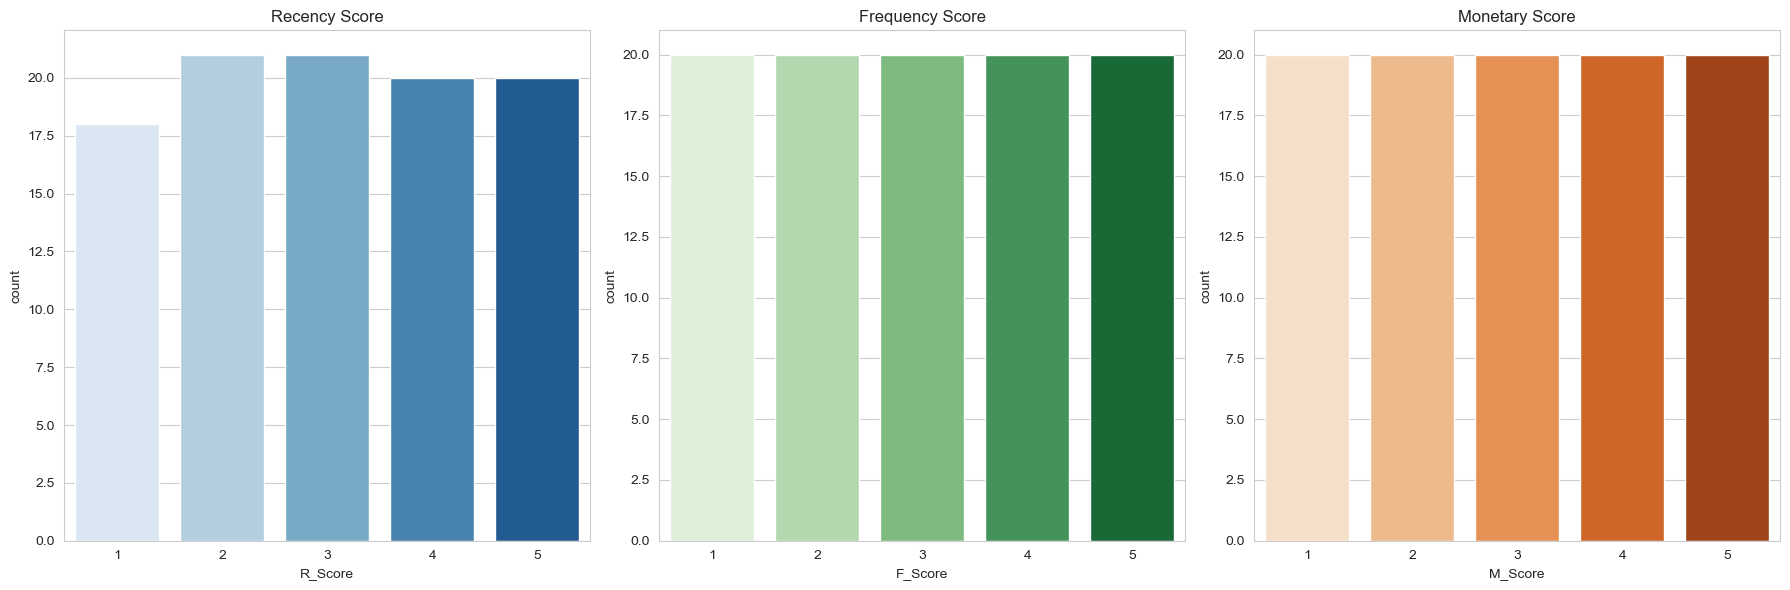

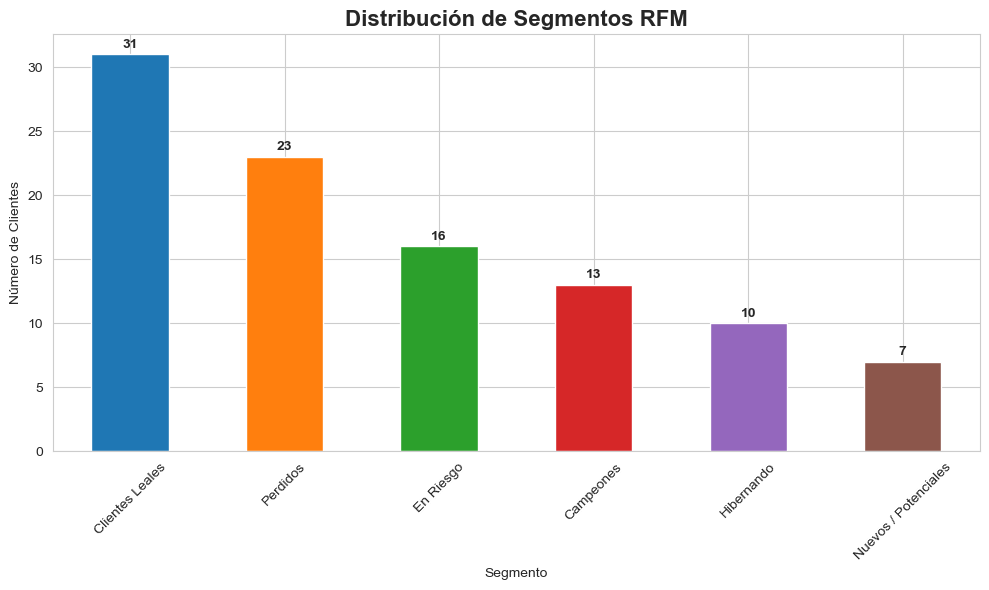

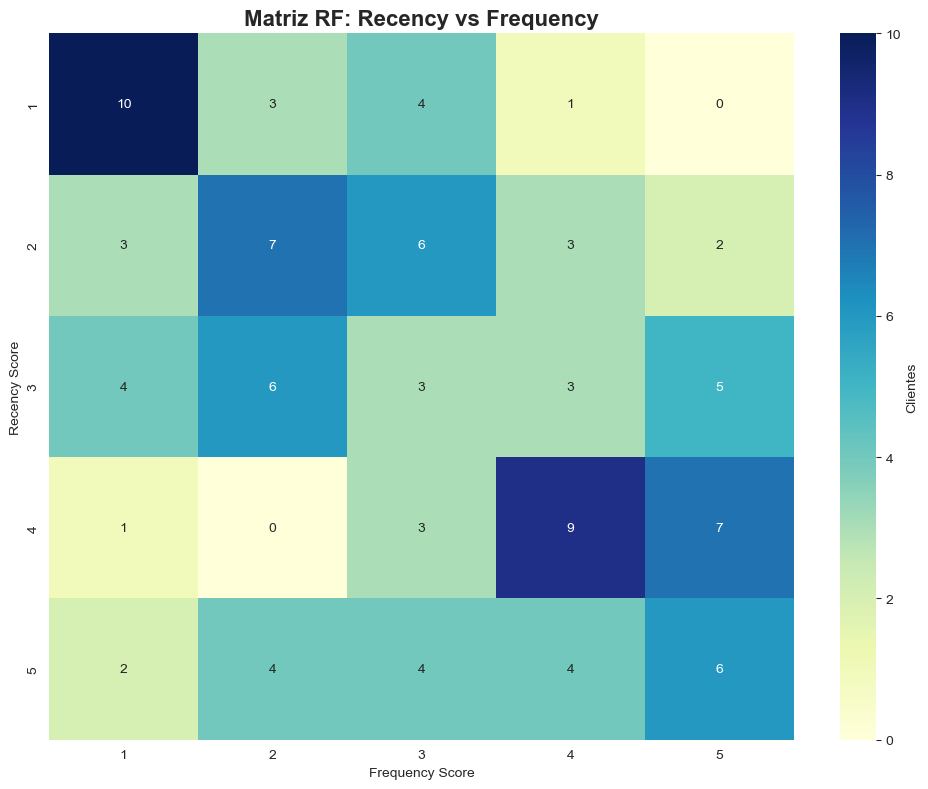

In [19]:
#GRÁFICOS ===
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Gráfico 1: Distribución de Scores
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.countplot(data=rfm, x='R_Score', ax=axes[0], palette='Blues')
axes[0].set_title('Recency Score')
sns.countplot(data=rfm, x='F_Score', ax=axes[1], palette='Greens')
axes[1].set_title('Frequency Score')
sns.countplot(data=rfm, x='M_Score', ax=axes[2], palette='Oranges')
axes[2].set_title('Monetary Score')
plt.tight_layout()
plt.show()

# Gráfico 2: Segmentos
plt.figure(figsize=(10, 6))
seg_count = rfm['Segmento'].value_counts()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
seg_count.plot(kind='bar', color=colors)
plt.title('Distribución de Segmentos RFM', fontsize=16, fontweight='bold')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=45)
for i, v in enumerate(seg_count):
    plt.text(i, v + 0.5, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# Gráfico 3: Matriz RF
plt.figure(figsize=(10, 8))
rf_matrix = rfm.pivot_table(index='R_Score', columns='F_Score', values='Cliente_ID', aggfunc='count', fill_value=0)
sns.heatmap(rf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Clientes'})
plt.title('Matriz RF: Recency vs Frequency', fontsize=16, fontweight='bold')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.tight_layout()
plt.show()



In [21]:
#EXPORTAR ===
rfm.to_excel("RFM_Analisis_Clientes.xlsx", index=False)
print("\nExportado: RFM_Analisis_Clientes.xlsx")


Exportado: RFM_Analisis_Clientes.xlsx


In [23]:
#RECOMENDACIONES AUTOMÁTICAS ===
print("\n" + "="*60)
print("RECOMENDACIONES ESTRATÉGICAS")
print("="*60)
campeones = len(rfm[rfm['Segmento']=='Campeones'])
leales = len(rfm[rfm['Segmento']=='Clientes Leales'])
riesgo = len(rfm[rfm['Segmento']=='En Riesgo'])
perdidos = len(rfm[rfm['Segmento']=='Perdidos'])

print(f"• Campeones ({campeones}): Programa VIP, upselling, referidos")
print(f"• Clientes Leales ({leales}): Fidelidad, descuentos por volumen")
print(f"• En Riesgo ({riesgo}): Campaña de reactivación (email, promo personalizada)")
print(f"• Perdidos ({perdidos}): Win-back con oferta irresistible o dar de baja")


RECOMENDACIONES ESTRATÉGICAS
• Campeones (13): Programa VIP, upselling, referidos
• Clientes Leales (31): Fidelidad, descuentos por volumen
• En Riesgo (16): Campaña de reactivación (email, promo personalizada)
• Perdidos (23): Win-back con oferta irresistible o dar de baja
